Victor Fleiser (28706870)

Frédéric Li Combeau (21400017)

Thomas Marchand (21113482)

# Notebook d'Analyse

### Imports et definitions de fonctions/données utilisées par la suite

In [1]:
# ------------------------------ IMPORTS ------------------------------

import os
import csv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# ------------------------------ READ LOGS ------------------------------
logs_path = "logs"
logs = []
sessions = {}
# log_files = [f for f in os.listdir(logs_path) if os.path.isfile(os.path.join(logs_path, f))]
log_files = ["logs.csv"]

for log_file in log_files:
	with open(os.path.join(logs_path, log_file), 'r', encoding="utf8") as f:
		reader = csv.DictReader(f)
		for log_dict in reader:
			logs.append(log_dict)

			session_id = log_dict['session_id']
			if session_id not in sessions:
				sessions[session_id] = []
			sessions[session_id].append(log_dict)

In [3]:
# posts in order from the code :
posts = [
	"https://www.reddit.com/r/philosophie/comments/vz90xf/pour_vous_quel_serait_le_sens_de_la_vie/",
	"https://x.com/thibaultbrock/status/1226080474289844224",
	"https://www.reddit.com/r/france/comments/tw35nv/avis_pour_robot_cuiseur/",
	"https://www.reddit.com/r/france/comments/uquq0g/estce_que_vous_avez_une_d%C3%A9formation/",
	"https://www.reddit.com/r/france/comments/iwiq5r/suggestions_de_hobby/",
	"https://www.reddit.com/r/france/comments/u3lgkb/questce_qui_rend_votre_m%C3%A9tier_indispensable/",
	"https://www.reddit.com/r/france/comments/uni1lh/que_peuton_faire_si_on_a_identifi%C3%A9_un_vendeur/",
	"https://www.reddit.com/r/france/comments/swj2pu/jai_trouv%C3%A9_du_roquefort_soci%C3%A9t%C3%A9_aux_usa_et_il_y_a/",
	"https://www.jeuxvideo.com/forums/42-3031-48483812-1-0-1-0-compatibilite-sauvegarde-entre-versions-sur-ps1.htm",
	"https://www.jeuxvideo.com/forums/42-3000003-70395444-1-0-1-0-trophees-non-debloque.htm",
	"https://www.reddit.com/r/Lyon/comments/tgzdyz/le_30_mars_2022_la_ville_de_lyon_passe_%C3%A0_30kmh/"
]
posts_titles = [
	"Post_Vie",
	"Post_Sonic",
	"Post_Cuiseur",
	"Post_Déformation",
	"Post_Hobby",
	"Post_Métier",
	"Post_Vol",
	"Post_Roquefort",
	"Post_PS1",
	"Post_Trophées",
	"Post_Lyon"
]

In [4]:
# ------------------------------ FUNCTIONS ------------------------------

def get_logs_with_field_value(logs, field_name, value):
	"""Retrieve logs from a list of logs with a specific field value."""
	return [log for log in logs if log.get(field_name) == value]

def remove_duplicate_session_id_and_trial_id_event_type(logs):
	"""From a list of logs, remove logs which have the same (session_id, trial_id, event_type), keeping only the last one.
	Used to remove the logs for actions that the user accidentally did multiple times -> keeping only the last one.""" 
	unique_logs = {}
	for log in logs:
		session_id = log['session_id']
		trial_id = log['trial_id']
		event_type = log['event_type']
		if not trial_id:
			continue
		key = (session_id, trial_id, event_type)
		if key not in unique_logs or log['timestamp'] > unique_logs[key]['timestamp']:
			unique_logs[key] = log
	return list(unique_logs.values())

def ai_decision_from_probability(probability):
	"""Determine AI decision based on output probability."""
	if probability is None or probability == '':
		return None
	if float(probability) > 0.5:
		return 'yes'
	elif float(probability) < 0.5:
		return 'no'
	else:
		return None

def ai_decision_correct(log):
	"""Determine if the AI decision was correct based on the log."""
	ai_output_probability = log['ai_output_probability']
	ai_generated_post = log['ai_generated_post']
	ai_decision = ai_decision_from_probability(ai_output_probability)
	if ai_generated_post == 'true' and ai_decision == 'yes':
		return 'YES'
	elif ai_generated_post == 'false' and ai_decision == 'no':
		return 'YES'
	else:
		return 'NO'

def get_unique_values_for_field_from_logs(logs, field_name):
	"""Retrieve values for a specific field from a list of logs."""
	return set([log.get(field_name) for log in logs if field_name in log])


Session: 5e009049-cd7a-4cd7-a98c-56ff34144a50


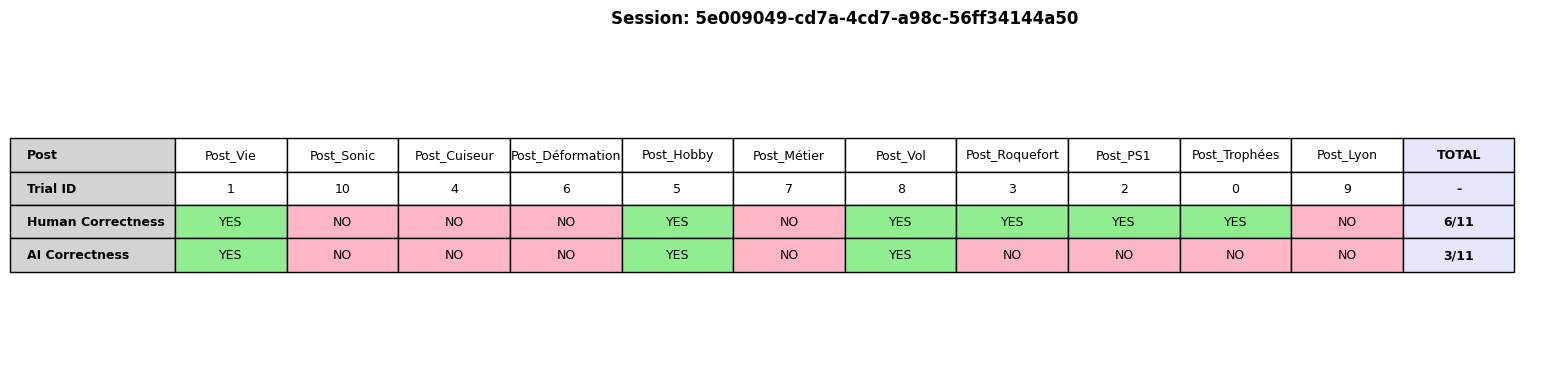


Session: 0c87a64d-c52f-47b4-9e81-2fe82ccadd21


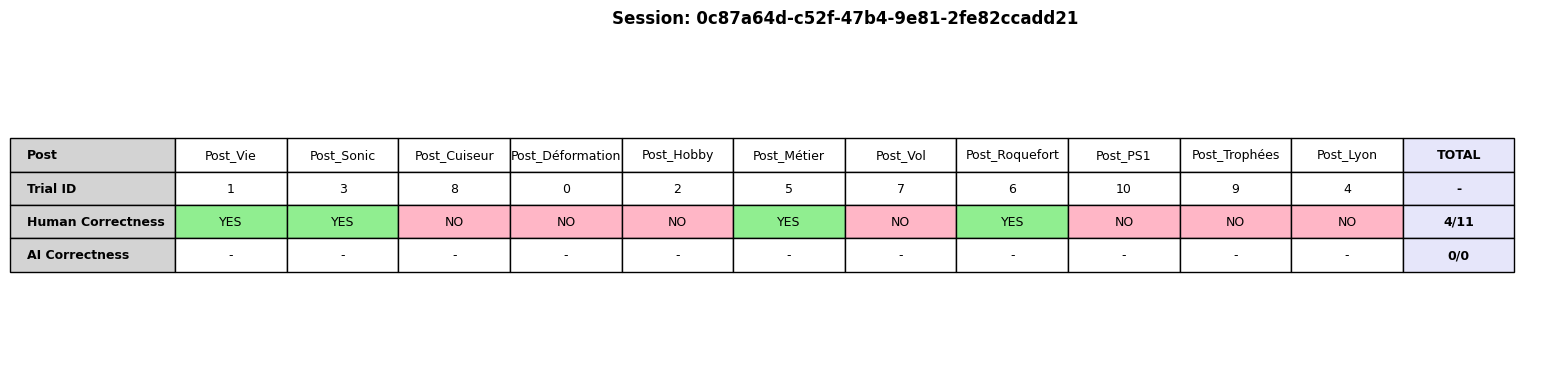


Session: 4f8f2609-e49a-47fa-a119-2f00332c19b2


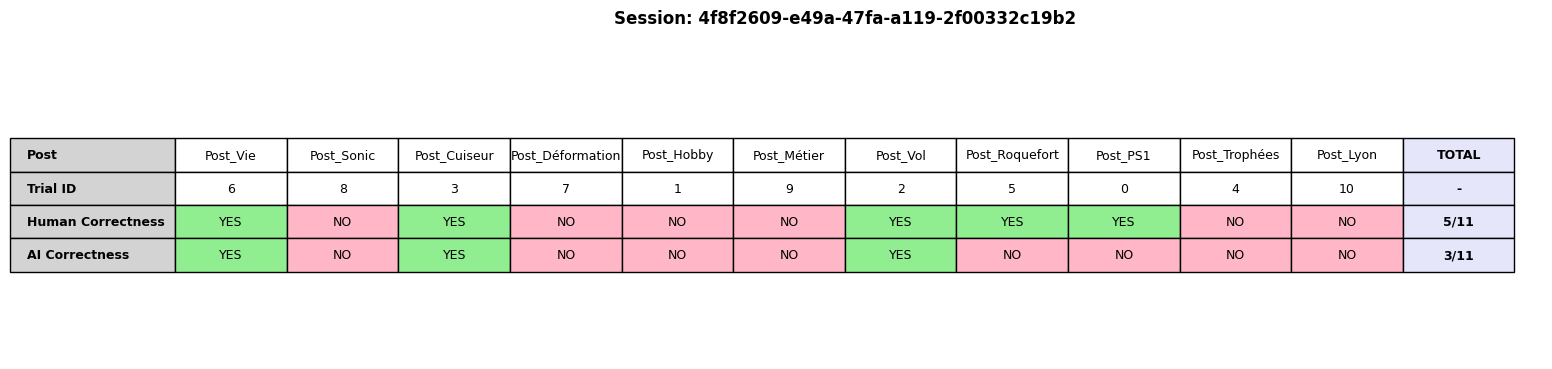


Session: cd9891c8-9017-4f57-83a5-c5faf90b3c38


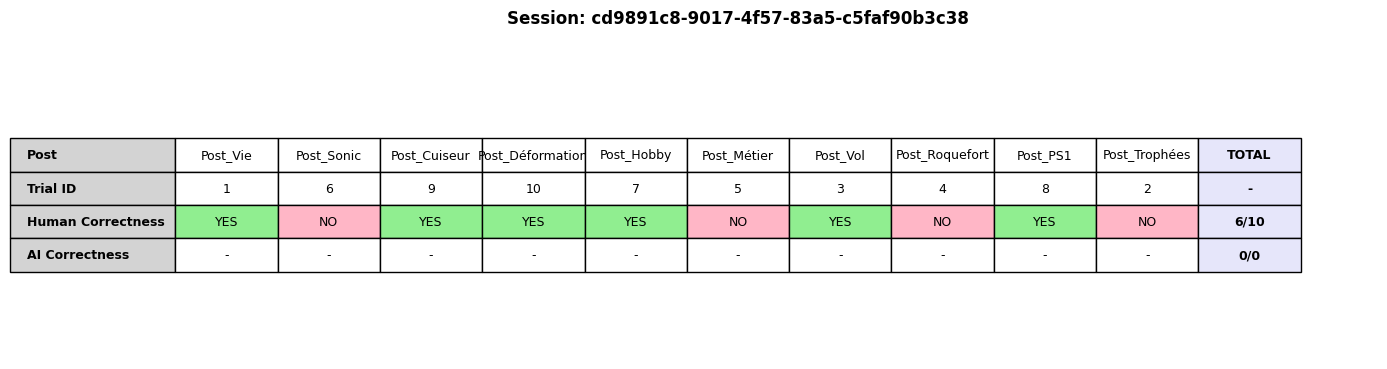


Session: 859ce8bd-eeb1-4d11-bcb4-bbe8c0899379


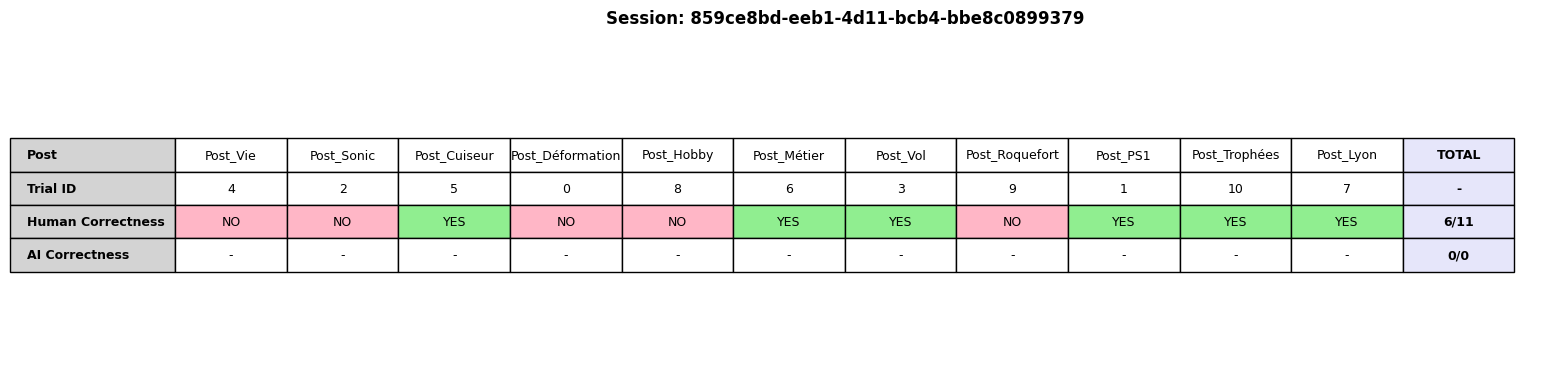


Session: 79d47041-a137-45c1-805f-745a821433bd


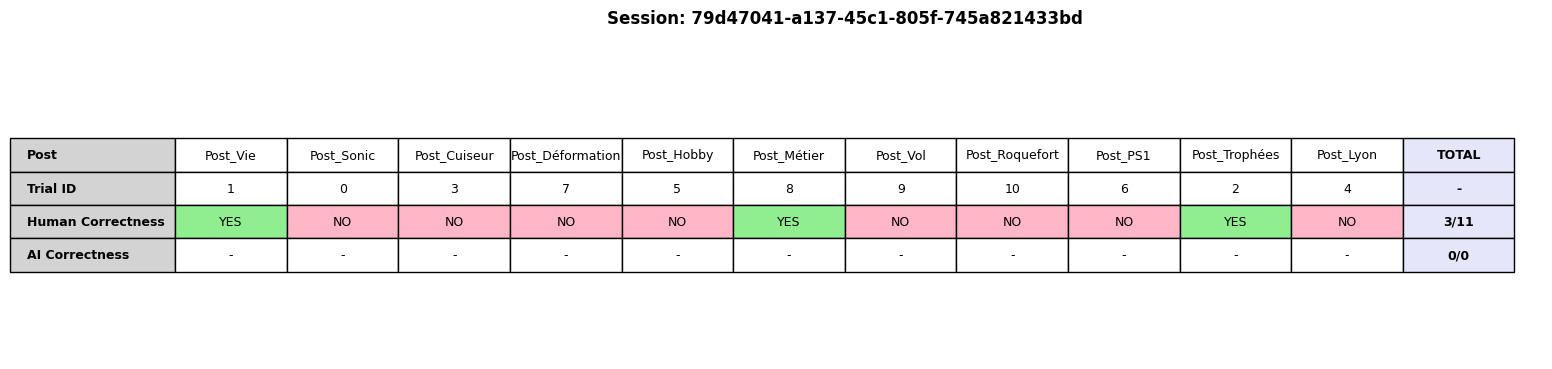


Session: eb391b69-2cf6-47fb-a125-03e7834eee51


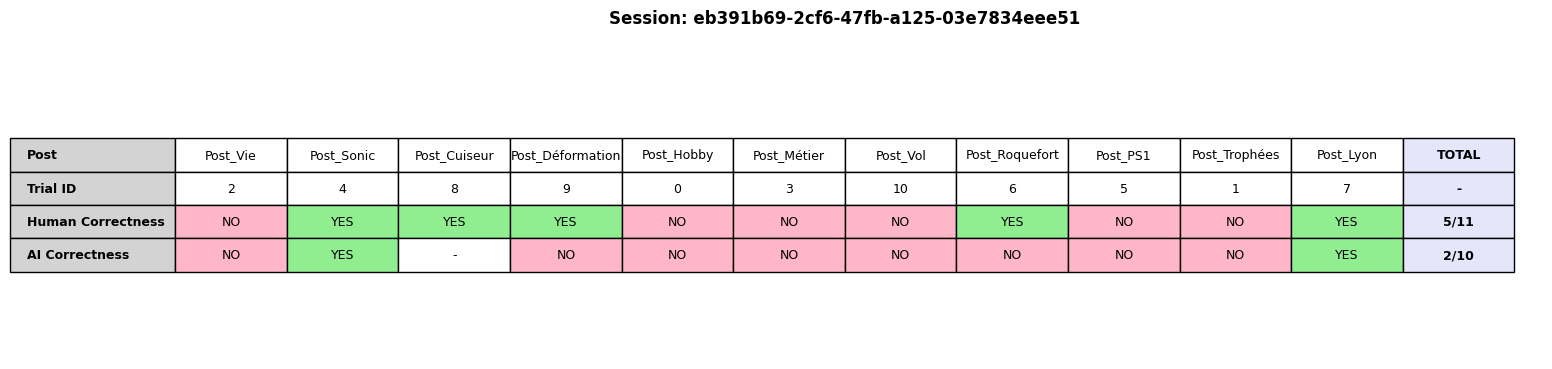


Session: 34475ce1-2bed-40c2-8f7f-8824b31129f8


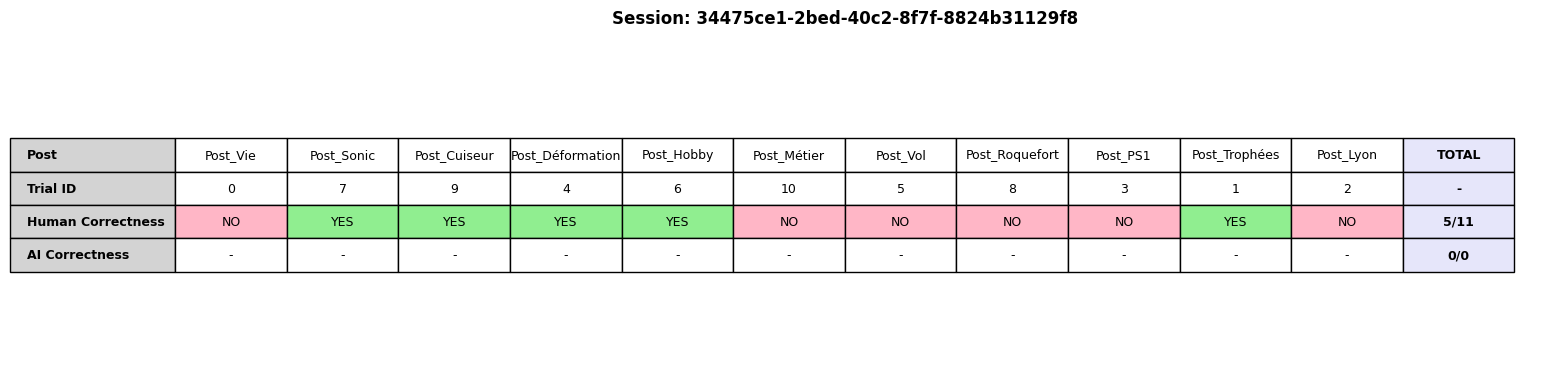


Session: 0b336e7d-eb3f-484f-8561-1ac65208d282


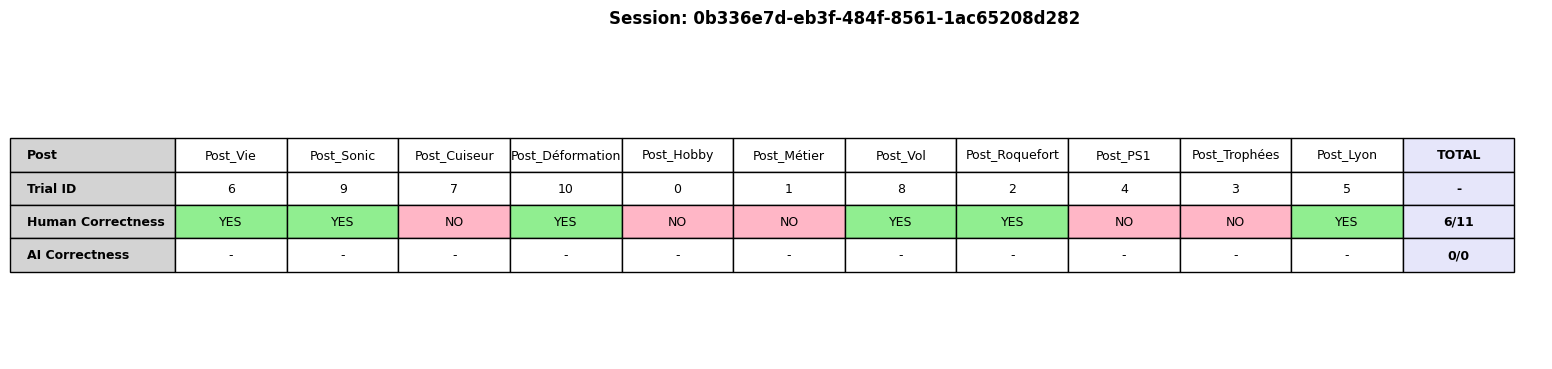


Session: 39391f72-13fc-4c71-b79c-ff38445d751c


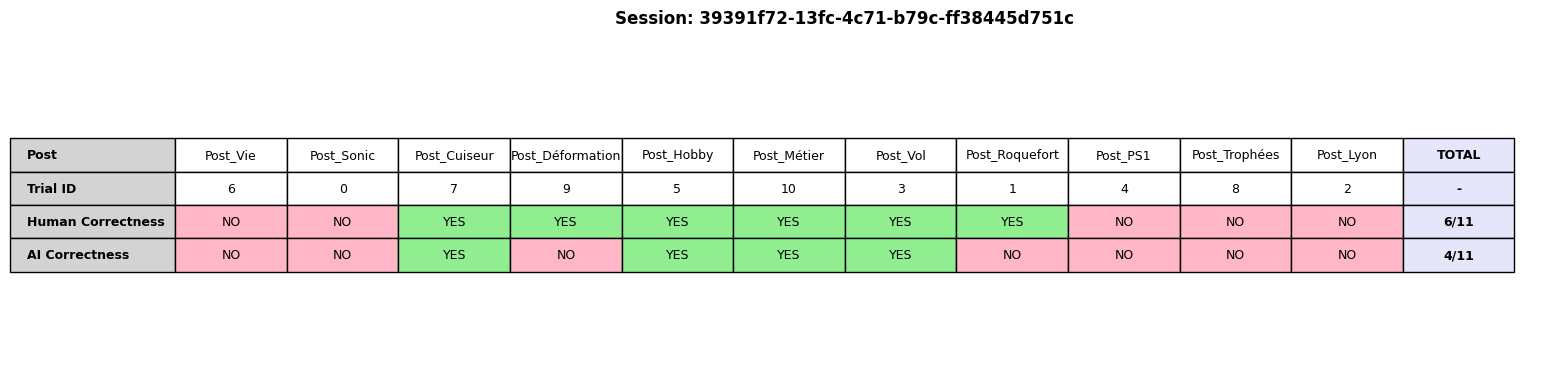


Session: 45fedb2b-28f6-49a8-8eb0-e28b4995c854


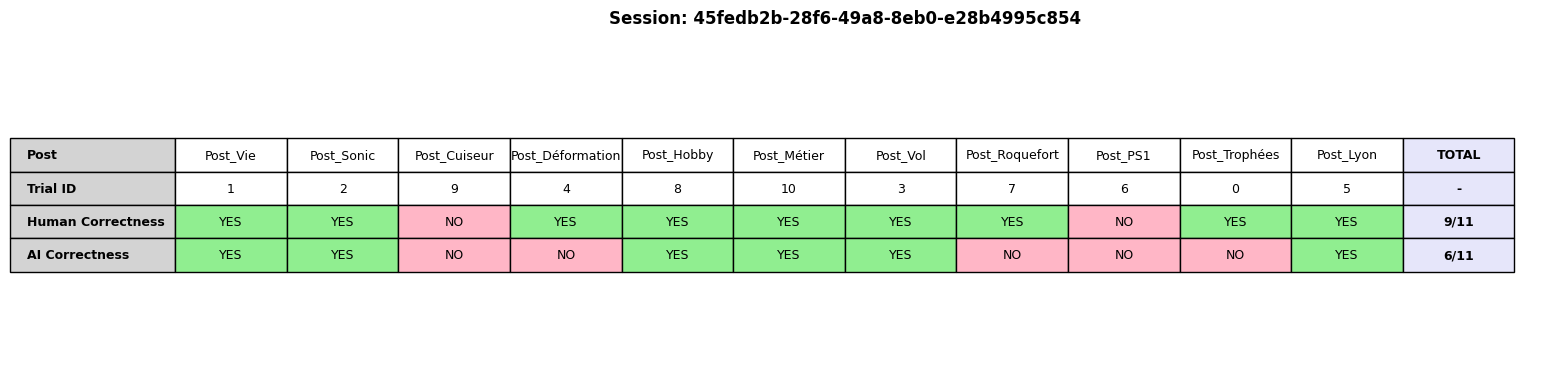


Session: facf3a21-00ca-4043-8cdb-64591d2c0783


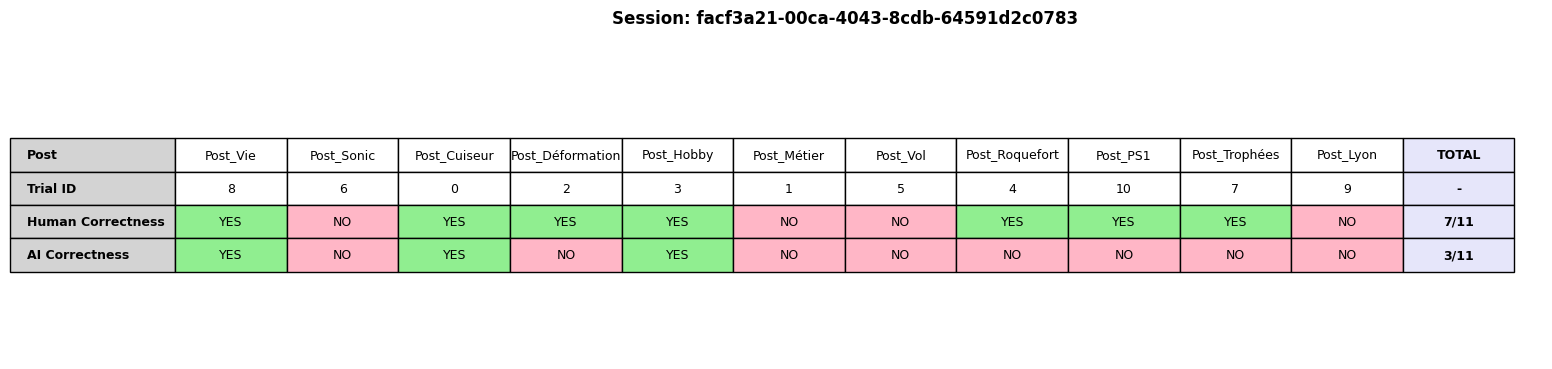


Session: 44499fec-db04-465c-9f98-ddb62f0e074d


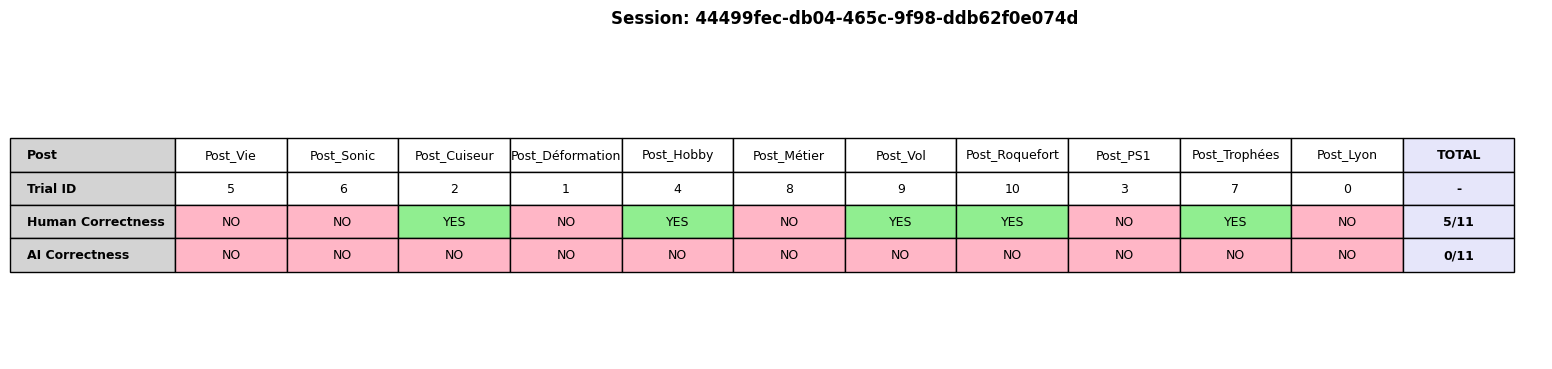

In [5]:
# ------------------------------ Show table of correctness for each session ------------------------------
# filter logs :
unique_logs = remove_duplicate_session_id_and_trial_id_event_type(logs)
decisions_human = get_logs_with_field_value(unique_logs, 'event_type', 'decision')
decisions_ai = get_logs_with_field_value(unique_logs, 'event_type', 'evaluation_ended')
decisions = decisions_human + decisions_ai

# for each session :
sessions_results = {}
for session_id in get_unique_values_for_field_from_logs(unique_logs, 'session_id'):
	session_logs = get_logs_with_field_value(unique_logs, 'session_id', session_id)
	results = {}
	for log in session_logs:
		if log['event_type'] == 'decision':
			results[(log['post'], "human")] = {"correct": log['correct'], "trial_id": log['trial_id']}
		elif log['event_type'] == 'evaluation_ended':
			correctness = ai_decision_correct(log)
			results[(log['post'], "ai")] = {"correct": correctness, "trial_id": log['trial_id']}
	sessions_results[session_id] = results

# Create a table for each session
for session_id, results in sessions_results.items():
	print(f"\nSession: {session_id}")
	
	# Initialize rows
	posts_display = []
	trial_ids = []
	human_correctness = []
	ai_correctness = []
	
	# Iterate through posts in order
	for idx, post_url in enumerate(posts):
		# Look for human decision for this post
		human_key = (post_url, "human")
		ai_key = (post_url, "ai")
		
		if human_key in results or ai_key in results:
			# Use the corresponding title from posts_titles
			posts_display.append(posts_titles[idx])
			
			# Get trial ID (prefer human, fallback to AI)
			trial_id = results[human_key]['trial_id'] if human_key in results else (results[ai_key]['trial_id'] if ai_key in results else '-')
			trial_ids.append(trial_id)
			
			# Get human correctness
			human_correct = results[human_key]['correct'] if human_key in results else '-'
			human_correctness.append(human_correct)
			
			# Get AI correctness
			ai_correct = results[ai_key]['correct'] if ai_key in results else '-'
			ai_correctness.append(ai_correct)
	
	# Calculate totals
	if posts_display:
		human_yes_count = sum(1 for x in human_correctness if x == 'YES')
		human_total = f"{human_yes_count}/{len([x for x in human_correctness if x != '-'])}"
		
		ai_yes_count = sum(1 for x in ai_correctness if x == 'YES')
		ai_total = f"{ai_yes_count}/{len([x for x in ai_correctness if x != '-'])}"
		
		# Add TOTAL column
		posts_display.append('TOTAL')
		trial_ids.append('-')
		human_correctness.append(human_total)
		ai_correctness.append(ai_total)
		
		# Create table data
		table_data = [
			posts_display,
			trial_ids,
			human_correctness,
			ai_correctness
		]
		
		# Create figure
		fig, ax = plt.subplots(figsize=(max(12, len(posts_display) * 1.5), 4))
		ax.axis('tight')
		ax.axis('off')
		
		# Create table
		table = ax.table(cellText=table_data,
						rowLabels=['Post', 'Trial ID', 'Human Correctness', 'AI Correctness'],
						cellLoc='center',
						loc='center',
						colWidths=[0.08] * len(posts_display))
		
		# Style the table
		table.auto_set_font_size(False)
		table.set_fontsize(9)
		table.scale(1, 2)
		
		# Color code the correctness cells
		for i, (h_correct, a_correct) in enumerate(zip(human_correctness, ai_correctness)):
			# Human correctness coloring
			if h_correct == 'YES':
				table[(2, i)].set_facecolor('#90EE90')  # Light green
			elif h_correct == 'NO':
				table[(2, i)].set_facecolor('#FFB6C6')  # Light red
			
			# AI correctness coloring
			if a_correct == 'YES':
				table[(3, i)].set_facecolor('#90EE90')  # Light green
			elif a_correct == 'NO':
				table[(3, i)].set_facecolor('#FFB6C6')  # Light red
		
		# Highlight TOTAL column
		for j in range(4):
			table[(j, len(posts_display)-1)].set_facecolor('#E6E6FA')  # Lavender
			table[(j, len(posts_display)-1)].set_text_props(weight='bold')
		
		# Style row labels
		for j in range(4):
			table[(j, -1)].set_facecolor('#D3D3D3')  # Light gray
			table[(j, -1)].set_text_props(weight='bold')
		
		plt.title(f'Session: {session_id}', fontsize=12, weight='bold', pad=20)
		plt.show()
	else:
		print("No data available for this session")

In [6]:
# ------------------------------ Calculate average scores by condition ------------------------------

# Get session conditions
session_conditions = {}
for session_id, session_logs in sessions.items():
	# Find the condition from the first log that has it
	for log in session_logs:
		if log.get('condition'):
			session_conditions[session_id] = log['condition']
			break

# Get unique conditions
conditions = set(session_conditions.values())

# Calculate scores for each condition
for condition in conditions:
	print(f"\n{'='*60}")
	print(f"Condition: {condition}")
	print('='*60)
	
	# Filter sessions with this condition
	condition_sessions = [sid for sid, cond in session_conditions.items() if cond == condition]
	
	# Initialize counters
	human_correct_total = 0
	human_decisions_total = 0
	ai_correct_total = 0
	ai_decisions_total = 0
	
	# Calculate scores for these sessions
	for session_id in condition_sessions:
		if session_id in sessions_results:
			results = sessions_results[session_id]
			
			# Count decisions
			for key, value in results.items():
				if key[1] == "human":  # human decision
					if value['correct'] == 'YES':
						human_correct_total += 1
					human_decisions_total += 1
				elif key[1] == "ai":  # ai decision
					if value['correct'] == 'YES':
						ai_correct_total += 1
					ai_decisions_total += 1
	
	# Calculate averages
	human_average_score = (human_correct_total / human_decisions_total * 100) if human_decisions_total > 0 else 0
	ai_average_score = (ai_correct_total / ai_decisions_total * 100) if ai_decisions_total > 0 else 0
	
	if condition == "User + AI":
		print(f"\nHuman + AI Performance")
	else:
		print(f"\nHuman Performance")
	print(f"  Correct: {human_correct_total}/{human_decisions_total}")
	print(f"  Average Score: {human_average_score:.2f}%")
	if condition == "User + AI":
		print(f"\nAI Performance:")
		print(f"  Correct: {ai_correct_total}/{ai_decisions_total}")
		print(f"  Average Score: {ai_average_score:.2f}%")



Condition: User + AI

Human + AI Performance
  Correct: 43/77
  Average Score: 55.84%

AI Performance:
  Correct: 21/76
  Average Score: 27.63%

Condition: User Alone

Human Performance
  Correct: 30/65
  Average Score: 46.15%


La performance Human + AI Performance est supérieure au maximum de la performance entre Human tout seul et AI tout seul.

TODO tester si la différence est significative